In [25]:
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np


In [26]:
class CustomDataset(Dataset):
    def __init__(self, labels_file, imgs_dir, transform=None, target_transform=None):
        self.labels = pd.read_csv(labels_file)
        self.imgs_dir = imgs_dir
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        img_path = os.path.join(self.imgs_dir, self.labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.labels.iloc[idx, 1]
        return image, label

In [27]:
training_dataset = CustomDataset('data/Train/Train.csv', 'data/Train/')
validation_dataset = CustomDataset('data/Valid/Validation.csv', 'data/Valid/')
test_dataset = CustomDataset('data/Test/Test.csv', 'data/Test/')

In [28]:
print(f"Training dataset size: {len(training_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 1569
Validation dataset size: 393
Test dataset size: 219


In [29]:
training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

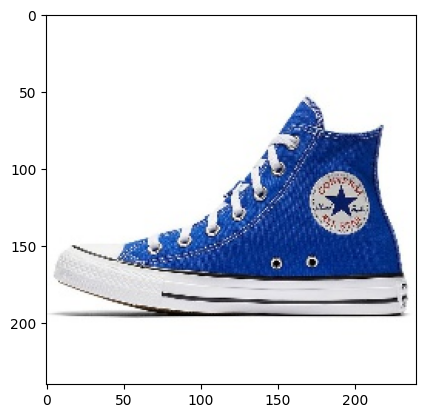

In [31]:
tst_img = validation_dataset.__getitem__(0)[0]
imshow(tst_img)

In [32]:
def extract_features(dataset):
    features = []
    labels = []
    for img, label in dataset:
        img_resized = cv2.resize(np.transpose(img.numpy(), (1, 2, 0)), (28, 28))
        # Convert image to grayscale
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        # Calculate HOG features
        features.append(hog(img_gray, 
                            orientations=9, 
                            pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), 
                            visualize=False))
        labels.append(label)
        
    return np.array(features), np.array(labels)

In [33]:
X_train, y_train = extract_features(training_dataset)
X_valid, y_valid = extract_features(validation_dataset)
X_test, y_test = extract_features(test_dataset)

In [34]:
print(f"Training feature shape:{X_train.shape}, Validation feature shape:{X_valid.shape}, Test feature shape:{X_test.shape}")
print(f"Training labels shape:{y_train.shape}, Validation labels shape:{y_valid.shape}, Test labels shape:{y_test.shape}")

Training feature shape:(1569, 144), Validation feature shape:(393, 144), Test feature shape:(219, 144)
Training labels shape:(1569,), Validation labels shape:(393,), Test labels shape:(219,)


# **KNN**

In [51]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
              'metric': ['euclidean', 'manhattan','cosine'],}

knn = KNeighborsClassifier()

knn_grid_search = GridSearchCV(knn, param_grid, cv=5)
knn_grid_search.fit(X_valid, y_valid)

print(f"Best parameters: {knn_grid_search.best_params_}")

Best parameters: {'metric': 'manhattan', 'n_neighbors': 11}


In [52]:
best_knn = knn_grid_search.best_estimator_
best_knn.fit(X_train, y_train)


KNeighborsClassifier(metric='manhattan', n_neighbors=11)

In [53]:
from sklearn.metrics import accuracy_score

y_knn_pred = best_knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_knn_pred)
print(f"KNN accuracy: {knn_accuracy}")

KNN accuracy: 0.8082191780821918


## **SVM**

In [66]:
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree': [2, 3, 4, 5]}

svc = SVC()

svc_grid_search = GridSearchCV(svc, param_grid)

svc_grid_search.fit(X_valid, y_valid)

print(f"Best parameters: {svc_grid_search.best_params_}")

Best parameters: {'C': 0.1, 'degree': 3, 'kernel': 'poly'}


In [67]:
best_svc = svc_grid_search.best_estimator_
# best_svc = SVC()
best_svc.fit(X_train, y_train)

SVC(C=0.1, kernel='poly')

In [68]:

y_svc_pred = best_svc.predict(X_test)
svc_accuracy = accuracy_score(y_test, y_svc_pred)
print(f"SVC accuracy: {svc_accuracy}")

SVC accuracy: 0.8584474885844748


## **Naive Bayes**

In [69]:
from sklearn.naive_bayes import GaussianNB

param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

nb = GaussianNB()

nb_grid_search = GridSearchCV(nb, param_grid)

nb_grid_search.fit(X_valid, y_valid)

print(f"Best parameters: {nb_grid_search.best_params_}")

Best parameters: {'var_smoothing': 1e-09}


In [70]:
best_nb = nb_grid_search.best_estimator_
# best_nb = GaussianNB()
best_nb.fit(X_train, y_train)

GaussianNB()

In [71]:

y_nb_pred = best_nb.predict(X_test)
nb_accuracy = accuracy_score(y_test, y_nb_pred)
print(f"Naive Bayes accuracy: {nb_accuracy}")

Naive Bayes accuracy: 0.821917808219178


## **Logistic Regression**

In [72]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']}

lr = LogisticRegression()

lr_grid_search = GridSearchCV(lr, param_grid)

lr_grid_search.fit(X_valid, y_valid)

print(f"Best parameters: {lr_grid_search.best_params_}")

Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [73]:
best_lr = lr_grid_search.best_estimator_
# best_lr = LogisticRegression()
best_lr.fit(X_train, y_train)

LogisticRegression(C=10, solver='liblinear')

In [74]:

y_lr_pred = best_lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_lr_pred)
print(f"Logistic Regression accuracy: {lr_accuracy}")

Logistic Regression accuracy: 0.863013698630137


## **Decision Tree**

In [84]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {'criterion': ['gini', 'entropy'],
                'max_depth': [None, 5, 10, 15, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],}

dt = DecisionTreeClassifier()

dt_grid_search = GridSearchCV(dt, param_grid)

dt_grid_search.fit(X_valid, y_valid)

print(f"Best parameters: {dt_grid_search.best_params_}")
                

Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [85]:
best_dt = dt_grid_search.best_estimator_
# best_dt = DecisionTreeClassifier()
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [87]:

y_dt_pred = best_dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_dt_pred)
print(f"Decision Tree accuracy: {dt_accuracy}")

Decision Tree accuracy: 0.7945205479452054


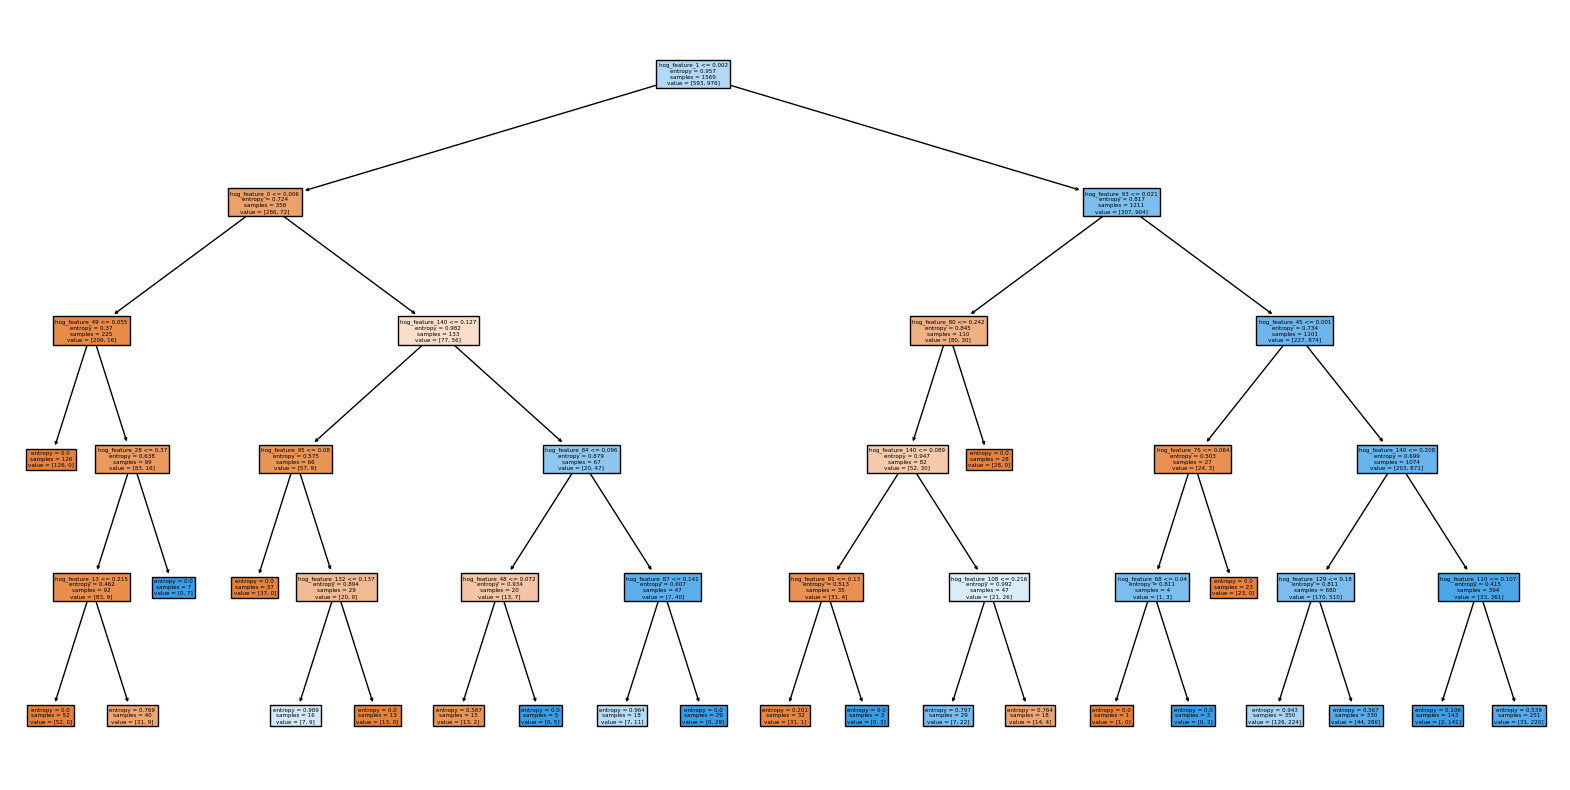

In [88]:
#print tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))

plot_tree(best_dt, filled=True, feature_names=['hog_feature_{}'.format(i) for i in range(X_train.shape[1])])
plt.show()


## **Random Forest**

In [93]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [50,80, 100],
              'max_depth': [ 5, 10, 15, 20],
              'max_features':[0.5, 0.7, 1.0],
              'min_samples_split': [2, 5, 10],}

rf = RandomForestClassifier(n_jobs=-1,random_state=42)

rf_grid_search = GridSearchCV(rf, param_grid)

rf_grid_search.fit(X_valid, y_valid)

print(f"Best parameters: {rf_grid_search.best_params_}")


Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_split': 10, 'n_estimators': 80}


In [100]:
best_rf = rf_grid_search.best_estimator_
# best_rf = RandomForestClassifier(n_jobs=-1)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=0.5, min_samples_split=10,
                       n_estimators=80, n_jobs=-1, random_state=42)

In [101]:

y_rf_pred = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_rf_pred)
print(f"Random Forest accuracy: {rf_accuracy}")


Random Forest accuracy: 0.8447488584474886


## **Comparing Models**

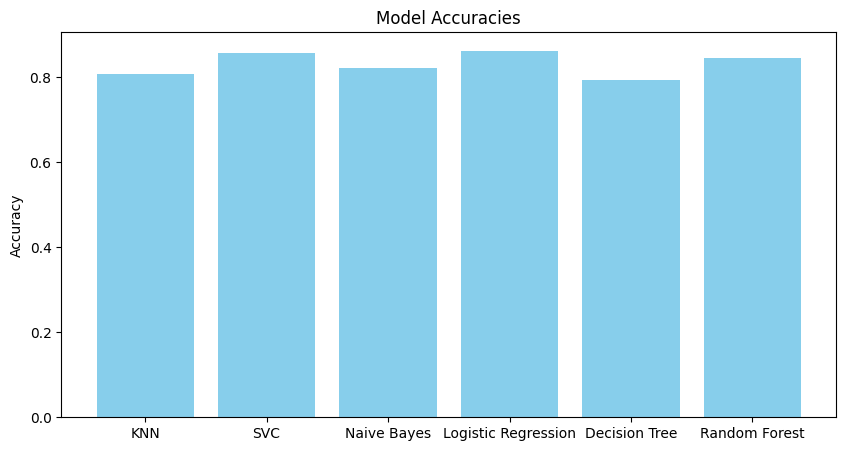

In [102]:
# plotting the accuracies
import matplotlib.pyplot as plt

models = ['KNN', 'SVC', 'Naive Bayes', 'Logistic Regression', 'Decision Tree', 'Random Forest']
accuracies = [knn_accuracy, svc_accuracy, nb_accuracy, lr_accuracy, dt_accuracy, rf_accuracy]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color='skyblue')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()